# Deep-Learning with Keras

#### Ugur URESIN, AI Engineer | Data Scientist
#### Mail: uresin.ugur@gmail.com

## Chapter 05. Neural Networks - Regression
### Dataset: Boston Housing

### The Steps
* **Step01**. Loading Dataset
* **Step02**. Assesing the Dataset
* **Step03**. Preparing the Dataset
* **Step04**. Building the network architecture
* **Step05**. The compilation and Training
* **Step06**. Creating a Validation Log

### Step 01. Loading Dataset

In [1]:
from keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

### Step 02. Assesing the Dataset

In [3]:
print("Training data dimensions:", train_data.shape)
print("Number of training labels:", len(train_targets))
print("Test data dimensions:", test_data.shape)
print("Number of test labels:", len(test_targets))

Training data dimensions: (404, 13)
Number of training labels: 404
Test data dimensions: (102, 13)
Number of test labels: 102


### Step03. Preparing the Dataset

#### Normalizing the datasets 

It would be problematic to feed into a neural network values that all take wildly different ranges.  
The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult.  
A widespread best practice to deal with such data is to do **feature-wise normalization**.  

For each feature in the input data (a column in the input data matrix),  
the mean of the feature is substracted and divided by the standard deviation,  
so that the feature is centered around 0 and has a unit standard deviation.

In [4]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

In [5]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

Note that the quantities used **for normalizing the test data** are computed **using the
training data**!!!  

<span style="color:red">
You should **never use any quantity computed on the test data!**  
    (Even for something as simple as data normalization)
</span>.

### Step04. Building the network architecture

In [9]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) #mae:mean-absolute-error
    return model

The network ends with a single unit and **no activation** (it will be a linear layer).   
This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value).

A new metric is monitored during training: **mean absolute error** (MAE).   
It’s the absolute value of the difference between the predictions and the targets.  
For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average.

### Step05. The Compilation and Training

#### k-fold validation

![k-fold validation](./img/kfold_Validation.png "k-fold validation")

In [10]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i+1)
    
    #preparing the validation data, from k'th partition of the data
    val_data    = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    #preparing the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [11]:
print("Scores: ", all_scores)
print("Mean score: ", np.mean(all_scores))

Scores:  [2.338947296142578, 2.427595615386963, 2.591632127761841, 2.3953707218170166]
Mean score:  2.4383864402770996


### Step06. Creation a Validation Log

In [12]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i+1)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


#### Building the history of successive mean K-fold validation scores

In [13]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

#### Plotting validation scores

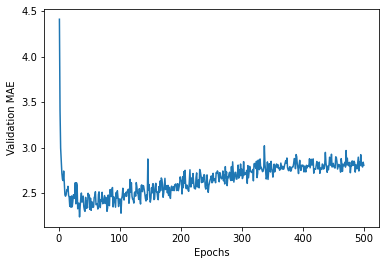

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Plotting validation scores, excluding the first 10 data points

In [15]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []

    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)

    return smoothed_points

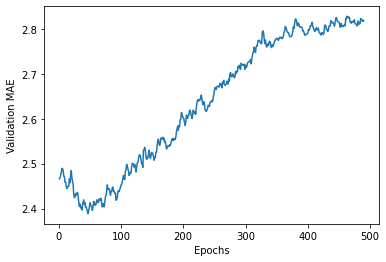

In [16]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()